In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from delase import DeLASE
from delase.metrics import mase
import h5py
from hydra import initialize, compose
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys
import torch
import numpy as np
from tqdm.auto import tqdm

# turn off HDF5 file locking
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

from UniversalUnconsciousness.data_utils import get_all_session_loc_roc_info, get_grid_params_to_use, find_noisy_data, get_noise_filter_info
from UniversalUnconsciousness.hdf5_utils import *
from UniversalUnconsciousness.iaaft import surrogates
from UniversalUnconsciousness.plot_utils import *

load_font()
plt.style.use('UniversalUnconsciousness.sci_style')

In [3]:
with initialize(version_base="1.3", config_path="../../UniversalUnconsciousness/DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [4]:
anesthetic_agent_list = cfg.plotting.anesthetic_agent_list
img_save_dir = cfg.plotting.img_save_dir

In [5]:
cfg.params.stride = 15
data_dir = f"/scratch2/weka/millerlab/eisenaj/UniversalUnconsciousness"
os.makedirs(os.path.join(data_dir, 'resting_state_analysis'), exist_ok=True)

resting_state_data = {}

max_window_length = 15
min_window_length = 3
for (data_class, agent) in anesthetic_agent_list:
    resting_state_data[(data_class, agent)] = {}
    cfg.params.data_class = data_class
    if 'propofol' in cfg.params.data_class:
        session_data_dir = os.path.join(cfg.params.all_data_dir, 'anesthesia', 'mat', cfg.params.data_class)
        session_list = [f[:-4] for f in os.listdir(session_data_dir) if f.endswith('.mat')]
        cfg.params.grid_set = 'grid_set6'
        # areas = ['all', 'vlPFC', 'FEF', '7b', 'CPB']
    else:
        session_data_dir = os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat')
        session_list = [f[:-4] for f in os.listdir(session_data_dir) if f.endswith('.mat')]
        session_list = [session for session in session_list if session not in ['PEDRI_Ketamine_20220203']]
        session_list = [session for session in session_list if agent.lower()[:3] in session.lower()]
        cfg.params.grid_set = 'grid_set6'

        # get only high dose sessions
        high_dose_session_list = []
        for session in session_list:
            session_file = h5py.File(os.path.join(cfg.params.all_data_dir, cfg.params.data_class, 'mat', session + '.mat'), 'r')
            dose = session_file['sessionInfo']['dose'][0, 0]
            if dose > 9:
                high_dose_session_list.append(session)
        session_list = high_dose_session_list

    session_lists, locs, rocs, ropaps = get_all_session_loc_roc_info(cfg, session_list, verbose=False)

    for monkey in session_lists:
        resting_state_data[(data_class, agent)][monkey] = {}
        for session in session_lists[monkey]['high']:
            resting_state_data[(data_class, agent)][monkey][session] = {}
            
            save_path = os.path.join(data_dir, 'resting_state_analysis', f"{session}_max_window_length_{max_window_length}_min_window_length_{min_window_length}.pkl")
            if os.path.exists(save_path):
                print(f"Skipping {session} because it already exists")
                resting_state_data[(data_class, agent)][monkey][session] = pd.read_pickle(save_path)
                continue
            
            print('-'*30)
            print(f"Session: {session}")
            print('-'*30)

            noise_filter_info = get_noise_filter_info(cfg, [session], force_new=False, verbose=True)

            section_info, section_info_extended, section_colors, infusion_start = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class, section_info_type='plot')
            session_file = h5py.File(os.path.join(session_data_dir,f"{session}.mat"), 'r')

            lfp = TransposedDatasetView(session_file['lfp']).transpose()
            dt = session_file['lfpSchema']['smpInterval'][0, 0]
            if data_class == 'propofolPuffTone':
                infusion_start = session_file['sessionInfo']['drugStart'][0, 0]
            else:
                infusion_start = session_file['sessionInfo']['infusionStart'][0, 0]

            valid_window_starts = noise_filter_info[session]['valid_window_starts']
            trial_starts = session_file['trialInfo']['trialStart'][:, 0]

            # Build list of maximal (start, end) windows satisfying constraints
            T = 3.0
            STEP = 15.0  # alignment/stride of valid windows

            # Ensure numpy arrays and sorted unique values
            valid_starts = np.asarray(valid_window_starts, dtype=float)
            valid_starts = np.unique(valid_starts)
            trial_starts_arr = np.asarray(trial_starts, dtype=float)
            trial_starts_arr = np.unique(trial_starts_arr)

            # Build a set for O(1) membership checks
            valid_start_set = set(valid_starts.tolist())

            # Identify contiguous valid blocks [block_start, block_end)
            blocks = []
            visited = set()
            for s in valid_starts:
                if s in visited:
                    continue
                # Find block start
                b = s
                while (b - STEP) in valid_start_set:
                    b -= STEP
                # Find block end (exclusive)
                e = s
                while (e + STEP) in valid_start_set:
                    e += STEP
                e += STEP  # make exclusive
                # mark all starts in this block as visited
                x = b
                while x < e:
                    visited.add(x)
                    x += STEP
                blocks.append((b, e))

            # For each block, create at most one window per trial: start=max(block_start, trial_start+T), end=min(block_end, next_trial_start)
            windows = []
            for (b, e) in blocks:
                # trials with trial_start + T < block_end can contribute
                i_end = int(np.searchsorted(trial_starts_arr + T, e, side='left'))
                for i in range(i_end):
                    s0 = max(b, trial_starts_arr[i] + T)
                    # next trial start (or +inf if none)
                    next_trial_start = trial_starts_arr[i + 1] if (i + 1) < len(trial_starts_arr) else float('inf')
                    e_max = min(e, next_trial_start)
                    if e_max > s0:
                        windows.append((float(s0), float(e_max)))

            # Sort and coalesce windows by merging overlaps to avoid redundant later starts producing identical ends
            windows.sort(key=lambda x: (x[0], x[1]))
            coalesced = []
            for s, e in windows:
                if not coalesced:
                    coalesced.append([s, e])
                    continue
                ps, pe = coalesced[-1]
                # If this window is contained within the last or has same end, extend the last to the union
                if s <= pe:
                    coalesced[-1][0] = min(ps, s)
                    coalesced[-1][1] = max(pe, e)
                else:
                    coalesced.append([s, e])

            windows = [(s, e) for s, e in coalesced]

            window_lengths = np.array([e - s for s, e in windows])
            max_window_length = 15
            min_window_length = 3
            windows_usable = np.array(windows)[(window_lengths <= max_window_length) & (window_lengths >= min_window_length)]

            session_list = [session]
            areas = ['all']
            area = 'all'
            verbose = False
            pca_chosen = None
            grid_params_to_use = get_grid_params_to_use(cfg, session_list, areas, noise_filter_info, pca_chosen, verbose=verbose)
            grid_params_to_use[session][area]

            windows_usable_starts = [w[0] for w in windows_usable]
            windows_usable_ends = [w[1] for w in windows_usable]

            section_times_mins_awake = section_info[np.where([section_info[i][0] == 'Awake' for i in range(len(section_info))])[0][0]][1]
            section_times_awake = np.array(section_times_mins_awake) * 60 + infusion_start
            awake_windows = windows_usable[(windows_usable_starts > section_times_awake[0]) & (windows_usable_ends < section_times_awake[1])]

            section_times_mins_anesthesia = section_info[np.where([section_info[i][0] == 'Anesthesia' for i in range(len(section_info))])[0][0]][1]
            section_times_anesthesia = np.array(section_times_mins_anesthesia) * 60 + infusion_start
            anesthesia_windows = windows_usable[(windows_usable_starts > section_times_anesthesia[0]) & (windows_usable_ends < section_times_anesthesia[1])]
        
            print(f"Awake windows: {len(awake_windows)}")
            print(f"Anesthesia windows: {len(anesthesia_windows)}")
            print(f"Total windows: {len(windows_usable)}")

            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            good_electrodes =np.array([i for i in np.arange(lfp.shape[1]) if i not in np.array(noise_filter_info[session]['bad_electrodes'])])
            resting_state_stability_rows = []
            n_delays = grid_params_to_use[session][area]['n_delays']
            rank = grid_params_to_use[session][area]['rank']
            for i, window in tqdm(enumerate(windows_usable), total=len(windows_usable)):
                lfp_chunk = lfp[int(window[0]/dt):int(window[1]/dt), good_electrodes]
                delase = DeLASE(
                    lfp_chunk,
                    max_freq=cfg.params.max_freq,
                    max_unstable_freq=cfg.params.max_unstable_freq,
                    dt=dt,
                    n_delays=n_delays,
                    rank=rank,
                    device=device,
                )
                delase.fit()
                stability_row = {
                    'stability_params': delase.stability_params.cpu().numpy(),
                    'window_start': window[0],
                    'window_end': window[1],
                    'window_length': window[1] - window[0],
                    'n_delays': n_delays,
                    'rank': rank,
                }
                resting_state_stability_rows.append(stability_row)
            resting_state_df = pd.DataFrame(resting_state_stability_rows)
            pd.to_pickle(resting_state_df, save_path)
            resting_state_data[(data_class, agent)][monkey][session] = resting_state_df

Skipping Mary-Anesthesia-20160818-02 because it already exists
Skipping Mary-Anesthesia-20160822-02 because it already exists
Skipping Mary-Anesthesia-20160809-01 because it already exists
Skipping Mary-Anesthesia-20160908-02 because it already exists
Skipping Mary-Anesthesia-20160902-02 because it already exists
Skipping Mary-Anesthesia-20160912-02 because it already exists
Skipping Mary-Anesthesia-20160916-02 because it already exists
Skipping Mary-Anesthesia-20160826-02 because it already exists
Skipping Mary-Anesthesia-20160914-02 because it already exists
Skipping Mary-Anesthesia-20160831-02 because it already exists
Skipping MrJones-Anesthesia-20160125-01 because it already exists
Skipping MrJones-Anesthesia-20160210-01 because it already exists
Skipping MrJones-Anesthesia-20160121-01 because it already exists
Skipping MrJones-Anesthesia-20160301-01 because it already exists
Skipping MrJones-Anesthesia-20160105-01 because it already exists
Skipping MrJones-Anesthesia-20160201-01 

In [6]:
top_percent = 0.1
n_its = 0
for (data_class, agent) in anesthetic_agent_list:
    for monkey in resting_state_data[(data_class, agent)]:
        for session in resting_state_data[(data_class, agent)][monkey]:
            n_its += 1
iterator = tqdm(total=n_its)
section_stabilities = {}
for (data_class, agent) in anesthetic_agent_list:
    section_stabilities[(data_class, agent)] = {}
    cfg.params.data_class = data_class
    for monkey in resting_state_data[(data_class, agent)]:
        section_stabilities[(data_class, agent)][monkey] = {}
        for session in resting_state_data[(data_class, agent)][monkey]:
            resting_state_df = resting_state_data[(data_class, agent)][monkey][session]
            
            # TRIM WINDOWS TO 3-3.5 SECONDS
            window_lengths = resting_state_df['window_length']
            length_bool = (window_lengths >= 3) & (window_lengths <= 3.5)
            top_percent_stability = resting_state_df['stability_params'].apply(lambda x: x[:int(top_percent*len(x))].mean())
            resting_state_df_trimmed = resting_state_df[length_bool]

            # GET SECTION STABILITY
            section_info, _, _, infusion_start = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class, section_info_type='plot')
            section_stability = {}
            for section in ['Awake', 'Anesthesia', 'Late Anesthesia']:
                section_start, section_end = section_info[np.where([info[0] == section for info in section_info])[0][0]][1]
                section_start = section_start * 60 + infusion_start
                section_end = section_end * 60 + infusion_start
                section_resting_state_df = resting_state_df_trimmed[(resting_state_df_trimmed['window_start'] >= section_start) & (resting_state_df_trimmed['window_end'] <= section_end)]
                section_stability[section] = section_resting_state_df.stability_params.apply(lambda x: x[:int(top_percent*len(x))].mean())

            section_stabilities[(data_class, agent)][monkey][session] = section_stability
            iterator.update(1)
iterator.close()

  0%|          | 0/53 [00:00<?, ?it/s]

In [7]:
def plot_section_stability(awake_stabilities, anesthesia_stabilities, ax):
    sections = ['Awake', 'Anesthesia']
    colors = [cfg.plotting.epoch_colors[section.lower()] for section in sections]
    data_to_plot = [awake_stabilities, anesthesia_stabilities]

    # Perform t-test
    from scipy.stats import wilcoxon
    stat, pvalue = wilcoxon(
        awake_stabilities, 
        anesthesia_stabilities, 
        alternative='less'
    )

    # Map p-value to significance stars
    def get_sig_stars(p):
        if p < 0.001:
            return '***'
        elif p < 0.01:
            return '**'
        elif p < 0.05:
            return '*'
        else:
            return 'ns'

    sig_stars = get_sig_stars(pvalue)

    bp = ax.boxplot(
        data_to_plot, 
        tick_labels=sections, 
        patch_artist=True,
        boxprops=dict(facecolor='lightgray', color='black'),
        medianprops=dict(color='black'),
        showfliers=False
    )

    # Set the background color of each box to the appropriate color
    for box, color in zip(bp['boxes'], colors):
        box.set_facecolor(color)

    # Calculate y-position for annotation
    # Get max top of plots for annotation
    y_max = max([d.max() if hasattr(d, 'max') else max(d) for d in data_to_plot])
    y_min = min([d.min() if hasattr(d, 'min') else min(d) for d in data_to_plot])
    y_range = y_max - y_min
    y_annot = y_max + 0.07 * y_range

    # Plot significance bar and stars
    x1, x2 = 1, 2  # positions for Awake and Anesthesia
    ax.plot([x1, x1, x2, x2], [y_max+0.04*y_range, y_annot, y_annot, y_max+0.04*y_range], color='k', lw=1)
    ax.text((x1+x2)/2, y_annot+0.02*y_range, sig_stars, ha='center', va='bottom', fontsize=7)

    ax.set_ylabel('Mean Resting\nState Instability ($s^{-1}$)')

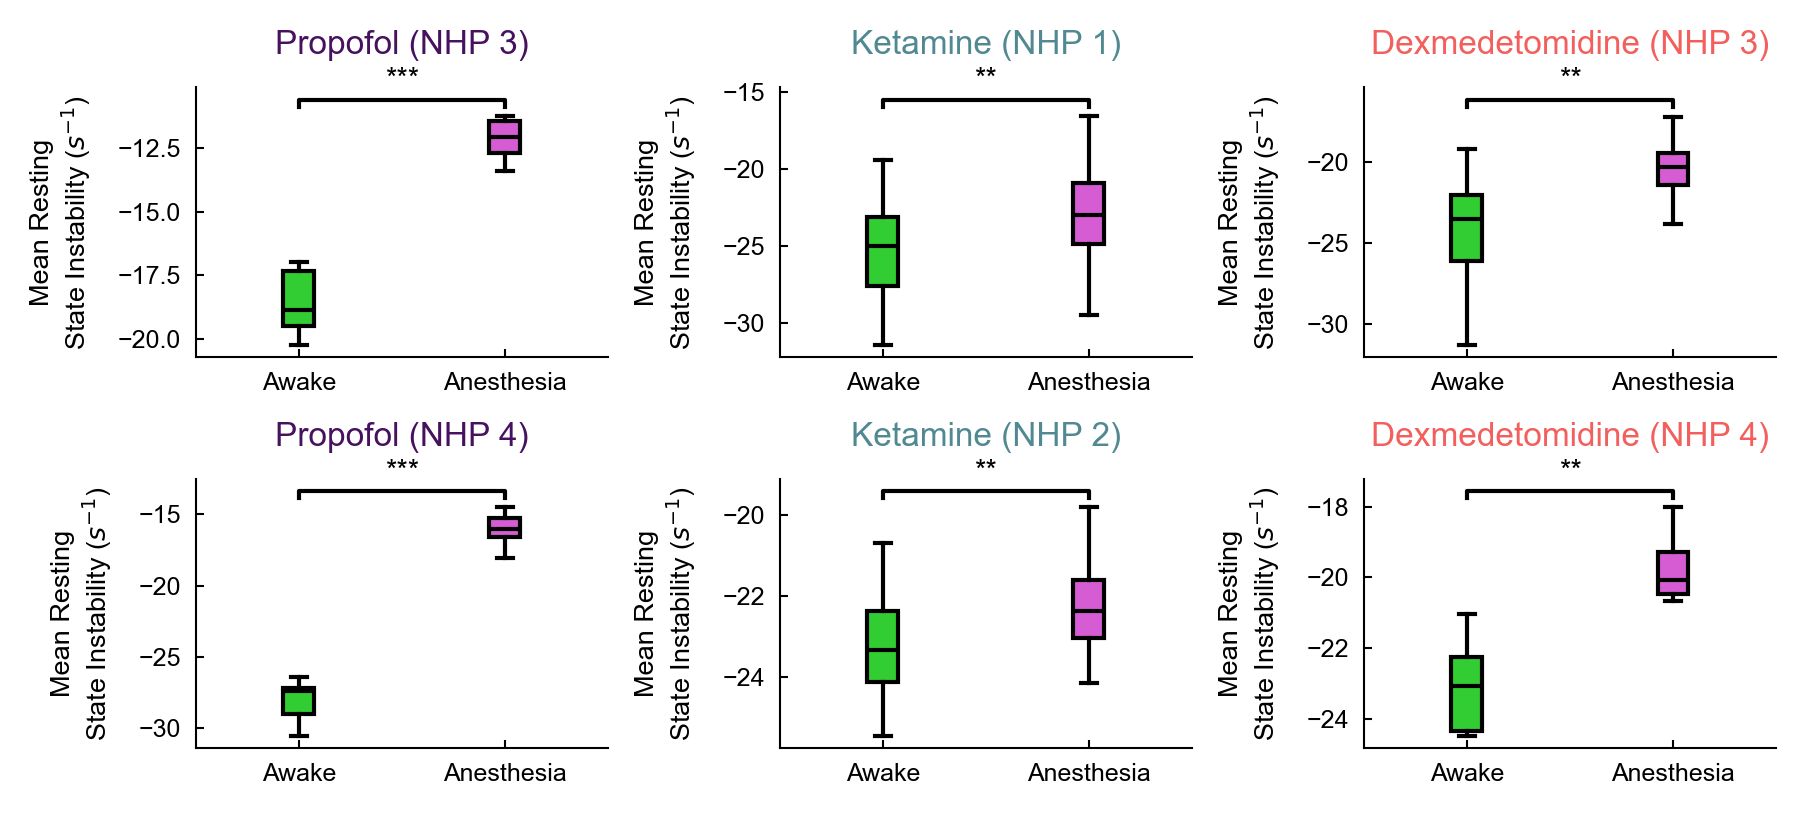

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(6, 2.7))

for j, (data_class, agent) in enumerate(anesthetic_agent_list):
    for i, monkey in enumerate(section_stabilities[(data_class, agent)]):
        awake_stabilities = [section_stabilities[data_class, agent][monkey][session]['Awake'].mean() for session in section_stabilities[data_class, agent][monkey]]
        anesthesia_stabilities = [section_stabilities[data_class, agent][monkey][session]['Anesthesia'].mean() for session in section_stabilities[data_class, agent][monkey]]

        ax = axs[i, j]
        plot_section_stability(awake_stabilities, anesthesia_stabilities, ax)

        ax.set_title(f"{agent.capitalize()} (NHP {i+1 if agent == 'ketamine' else i+3})", color=cfg.plotting.curve_colors[agent.lower()])
plt.tight_layout()
plt.savefig(os.path.join(img_save_dir, 'supp', 'resting_state_stability.pdf'), transparent=True, bbox_inches='tight')
plt.show()